In [1]:
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters

from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask
from tqdm import tqdm

In [2]:
feature_size = 2
output_size = 3
hidden_size = 401
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\models\\only_dm_lif_refrac\\max_accuracy\\_lr_0.001_N_401_number_1990"
        )
    )
number_of_tasks = 1

In [35]:
dt = 1e-3
subgroup_finder = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = 0
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out1, states = model(inputs, first_state)
    s1 = []
    for j in range(len(states)):
        s1.append(states[j].lif.z)
    s1 = torch.stack(s1).detach()
    s1 = s1.reshape((s1.shape[0], s1.shape[2]))
    subgroup_finder.compute_average_freq([s1], [inputs[:, 0, 0]], [out1], [t_outputs])

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


In [36]:
dt = 1e-3
subgroup_finder2 = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = 1
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out2, states = model(inputs, first_state)
    s2 = []
    for j in range(len(states)):
        s2.append(states[j].lif.z)
    s2 = torch.stack(s2).detach()
    s2 = s2.reshape((s2.shape[0], s2.shape[2]))
    subgroup_finder2.compute_average_freq([s2], [inputs[:, 0, 0]], [out2], [t_outputs])

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


In [37]:
plt.plot(times, out1.detach().numpy()[:, 0, 0, 1], c="b")
plt.plot(times, out1.detach().numpy()[:, 0, 0, 2], c="r")
plt.plot(times, out1.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.2)

plt.plot(2 * times, out2.detach().numpy()[:, 0, 0, 1], c="b")
plt.plot(2 * times, out2.detach().numpy()[:, 0, 0, 2], c="r")
plt.plot(2 * times, out2.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.2)

In [40]:
s1.shape

torch.Size([1050, 401])

In [41]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

s = torch.concat((s1, s2), axis=0)
strenght_first = np.load("strenght_first.npy")
s_np = s.detach().cpu().numpy().T
list_numbers = [i for i in range(len(s_np))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
s_np_sort = np.zeros_like(s_np)
for i in range(len(list_numbers)):
    s_np_sort[i, :] = s_np[list_numbers_sort[i], :]

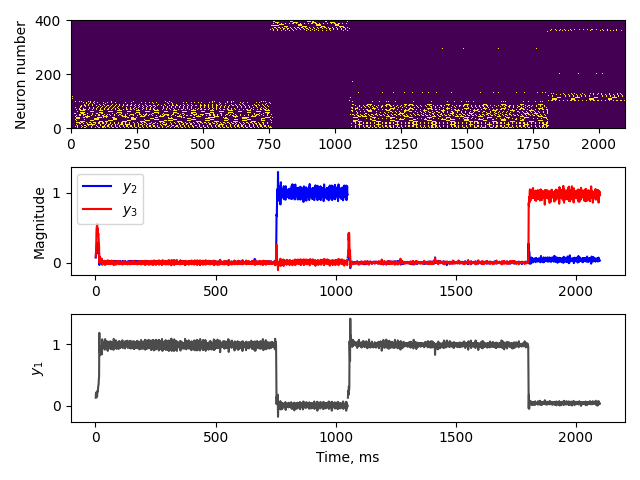

In [72]:
%matplotlib widget
times = np.arange(1, len(out1) + 1)
times_2 = times + times[-1]
fig = plt.figure()
fig.add_subplot(311)
plt.imshow(s_np_sort, aspect="auto", interpolation="None", origin="lower")
plt.ylabel("Neuron number")
fig.add_subplot(312)
plt.plot(times, out1.detach().numpy()[:, 0, 0, 1], c="b")
plt.plot(times, out1.detach().numpy()[:, 0, 0, 2], c="r")


plt.plot(times_2, out2.detach().numpy()[:, 0, 0, 1], c="b", label=rf"$y_2$")
plt.plot(times_2, out2.detach().numpy()[:, 0, 0, 2], c="r", label=rf"$y_3$")
plt.ylabel("Magnitude")
plt.legend()

fig.add_subplot(313)

plt.plot(times, out1.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.7)
plt.plot(
    times_2, out2.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.7, label=rf"$y_1$"
)
plt.xlabel("Time, ms")
plt.ylabel("$y_1$")
plt.tight_layout()
plt.savefig("Два испытания растрограмма и выходы.pdf")
plt.show()

In [63]:
2 * times

array([   2,    4,    6, ..., 2096, 2098, 2100])

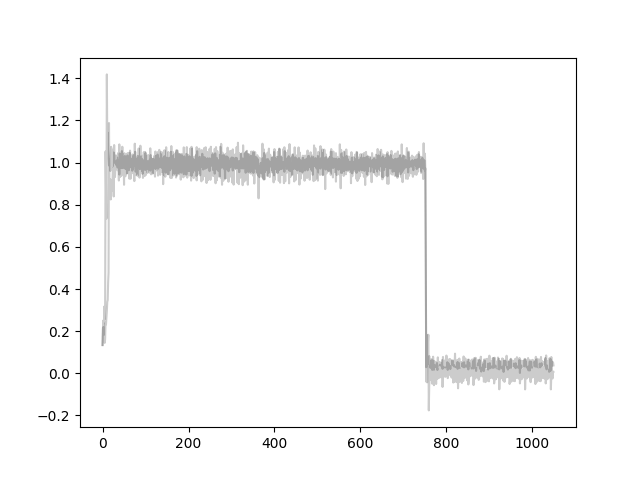

In [59]:
plt.figure()
plt.plot(times, out1.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.2)
plt.plot(2 * times, out2.detach().numpy()[:, 0, 0, 0], c="black", alpha=0.2)

In [14]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach())

In [15]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
strenght_second = answer_second * out_weights[2, :]
strenght_first_freq_second_out = answer_first * out_weights[2, :]
strenght_second_freq_first_out = answer_second * out_weights[1, :]

strenght_first_freq_fixation = fixation_first * out_weights[1, :]
strenght_second_freq_fixation = fixation_second * out_weights[2, :]
strenght_first_freq_second_out_fixation = fixation_first * out_weights[2, :]
strenght_second_freq_first_out_fixation = fixation_second * out_weights[1, :]

strenght_first_sort = sort_elemnts_by_another(strenght_first, strenght_first)
strenght_second_sort = sort_elemnts_by_another(strenght_first, strenght_second)
strenght_first_freq_second_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out
)
strenght_second_freq_first_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out
)

strenght_first_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_fixation
)
strenght_second_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_fixation
)
strenght_first_freq_second_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out_fixation
)
strenght_second_freq_first_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out_fixation
)

In [46]:
def plot_hist(data):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c="b")

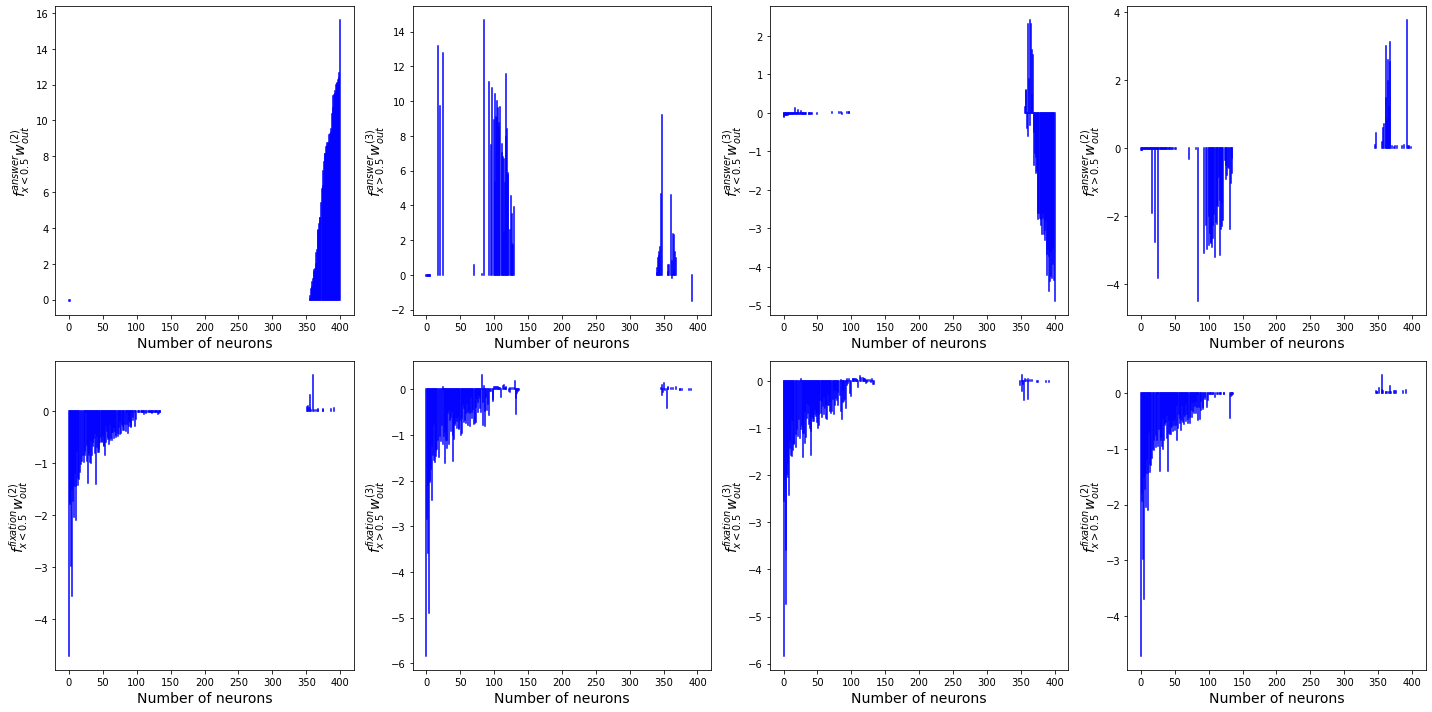

In [47]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))
plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_sort.numpy())

plt.subplot(243)
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_sort.numpy())

plt.subplot(244)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_sort.numpy())

plt.subplot(245)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_fixation_sort.numpy())

plt.subplot(246)
plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_fixation_sort.numpy())


plt.subplot(247)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_fixation_sort.numpy())

plt.subplot(248)

plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_fixation_sort.numpy())
plt.tight_layout()
plt.savefig("freq_strenght.pdf")
plt.show()

In [17]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
# strenght_first = answer_first * out_weights[1, :]
fixation_first_sort = sort_elemnts_by_another(strenght_first, fixation_first)
fixation_second_sort = sort_elemnts_by_another(strenght_first, fixation_second)
answer_first_sort = sort_elemnts_by_another(strenght_first, answer_first)
answer_second_sort = sort_elemnts_by_another(strenght_first, answer_second)
out1_sort = sort_elemnts_by_another(strenght_first, out_weights[0, :])
out2_sort = sort_elemnts_by_another(strenght_first, out_weights[1, :])
out3_sort = sort_elemnts_by_another(strenght_first, out_weights[2, :])

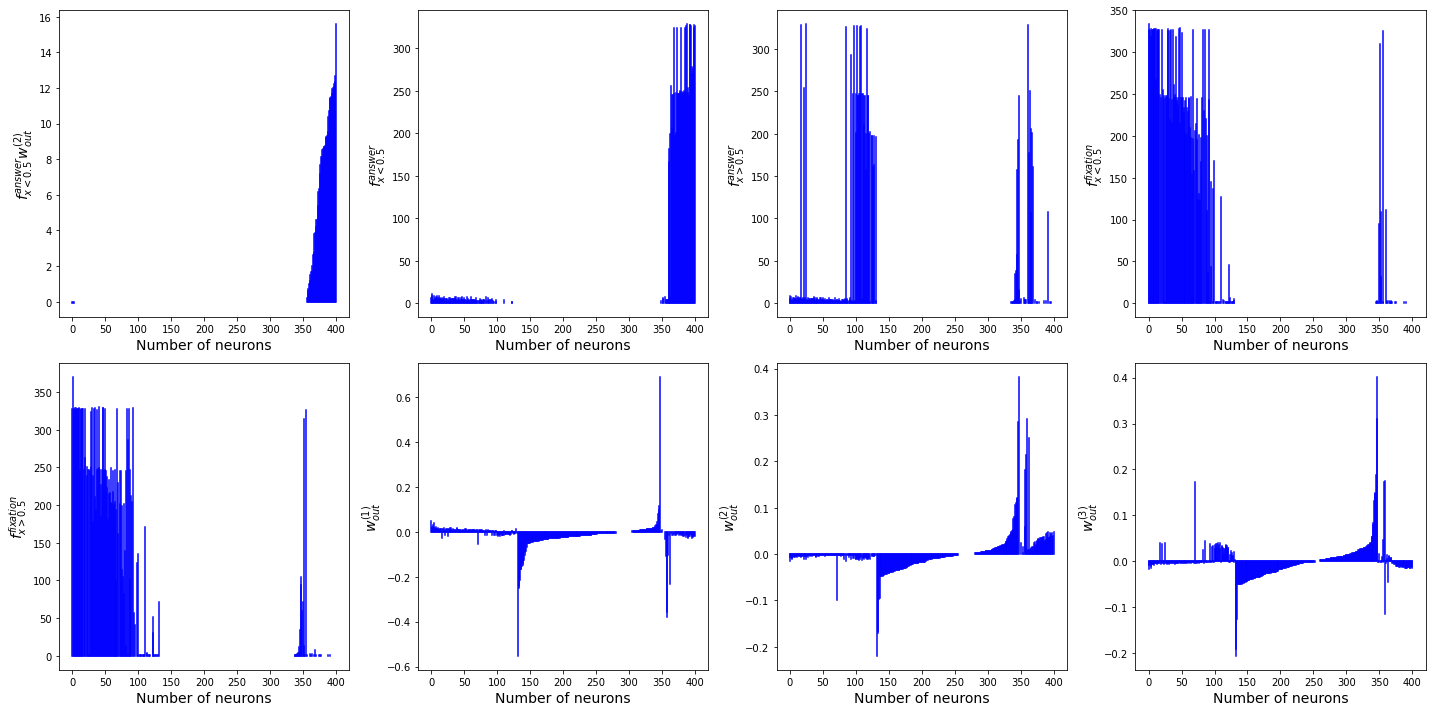

In [45]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
plt.savefig("freq.pdf")
plt.show()

In [19]:
for name, params in model.named_parameters():
    if name == "lif_refrac.recurrent_weights":
        rec_weights = torch.clone(params.detach())

list_numbers = [i for i in range(len(rec_weights))]

In [20]:
for name, params in model.named_parameters():
    if name == "lif_refrac.input_weights":
        input_weights = torch.clone(params.detach())

In [21]:
input_weights.shape

torch.Size([401, 2])

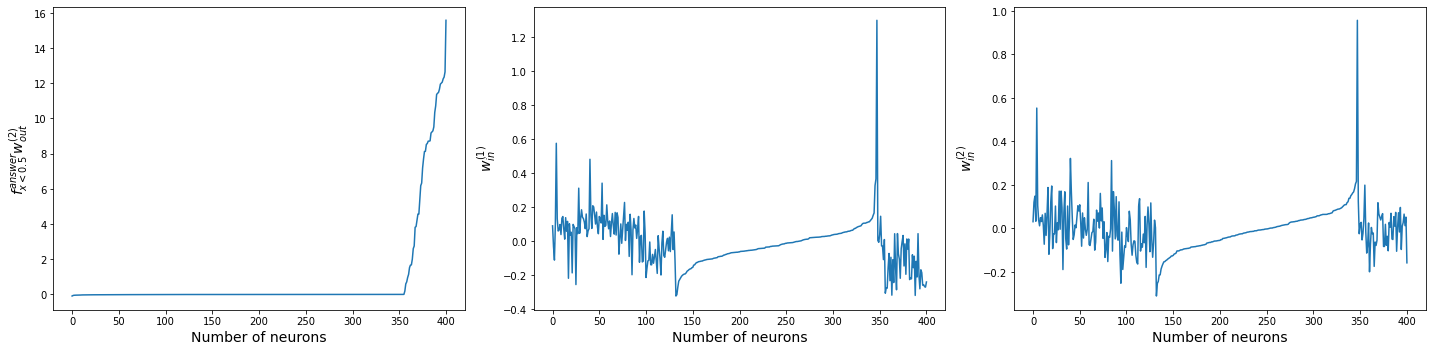

In [22]:
input_sort_1 = sort_elemnts_by_another(strenght_first, input_weights[:, 0])
input_sort_2 = sort_elemnts_by_another(strenght_first, input_weights[:, 1])

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.subplot(132)
plt.plot(input_sort_1.numpy())
plt.ylabel(r"$w_{in}^{(1)}$")
plt.xlabel("Number of neurons")
plt.subplot(133)
plt.plot(input_sort_2.numpy())
plt.ylabel(r"$w_{in}^{(2)}$")
plt.xlabel("Number of neurons")
plt.tight_layout()
plt.savefig("w_in.pdf")
plt.show()

In [23]:
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)

In [24]:
rec_weights_sort = torch.zeros_like(rec_weights)

for i in range(len(list_numbers)):
    rec_weights_sort[i] = rec_weights[list_numbers_sort[i]]

C:\Users\slava\AppData\Local\Temp/ipykernel_32512/2170375385.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("rec_w.pdf", interpolation="None")


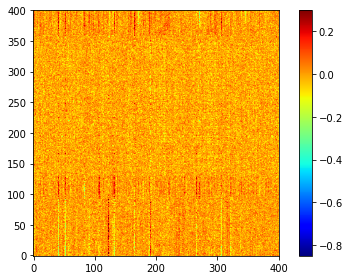

In [25]:
plt.imshow(rec_weights_sort.numpy(), origin="lower", vmax=0.3, cmap="jet")
plt.colorbar()
plt.tight_layout()
plt.savefig("rec_w.pdf", interpolation="None")

# SELECTIVITY

In [27]:
dt = 1e-3

init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
values = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
Neurons_frequency_fixation = np.zeros((hidden_size, len(values)))
Neurons_frequency_answer = np.zeros((hidden_size, len(values)))
number_of_tasks = 100
for value_i in tqdm(range(len(values))):
    subgroup_finder_choose = SubgroupFinder(dt)
    for i in range(number_of_tasks):

        dmparams1 = DefaultParams("DMTask").generate_params()
        dmparams1["value"] = values[value_i]
        task = DMTask(dmparams1, mode="value")
        inputs, t_outputs = task.dataset(1)
        inputs = torch.from_numpy(inputs).type(torch.float32)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
        out, states = model(inputs, first_state)
        s = []
        for j in range(len(states)):
            s.append(states[j].lif.z)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        subgroup_finder_choose.compute_average_freq(
            [s], [inputs[:, 0, 0]], [out], [t_outputs]
        )
    Neurons_frequency_fixation[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[0].cpu()
    ).numpy()
    Neurons_frequency_answer[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[1].cpu()
    ).numpy()

100%|██████████| 10/10 [06:38<00:00, 39.85s/it]


In [76]:
Neurons_frequency_fixation_copy = torch.from_numpy(Neurons_frequency_fixation).type(
    torch.float
)
Neurons_frequency_answer_copy = torch.from_numpy(Neurons_frequency_answer).type(
    torch.float
)

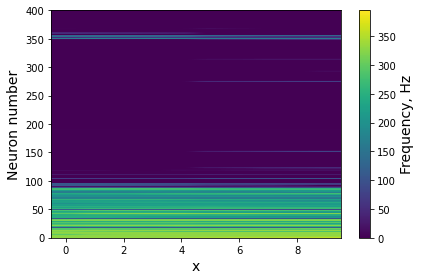

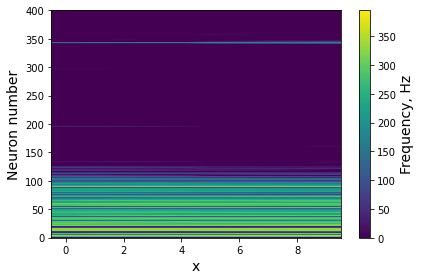

In [142]:
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_first.pdf")
plt.show()
plt.close()
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_second.pdf")
plt.show()
plt.close()

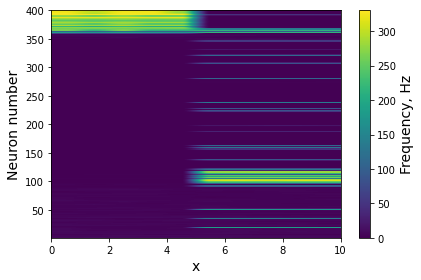

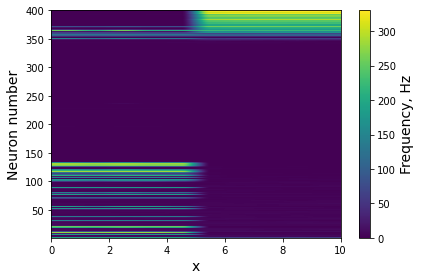

In [132]:
# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_first.pdf")
plt.show()
plt.close()

# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_second.pdf")
plt.show()
plt.close()

In [106]:
Neurons_frequency_answer_sort.shape

torch.Size([401, 10])

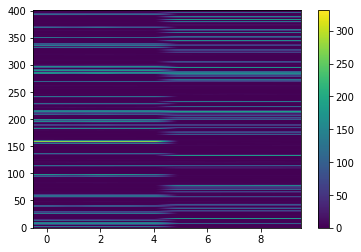

In [87]:
plt.imshow(Neurons_frequency_answer, aspect="auto", origin="lower")
plt.colorbar()

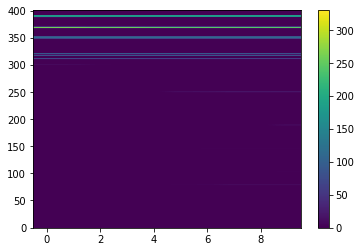

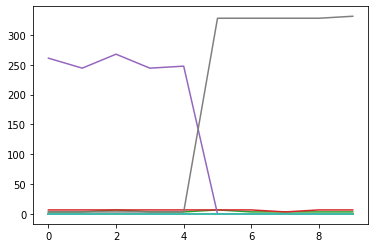

In [61]:
for i in range(10, 20):
    plt.plot(Neurons_frequency_answer_copy[i, :])